# <font color = '#e64626'><center>QBUS6810 Group Assignment</center></font>
### <center>Group 18: 490347812, , , , , </center>

# Table of Contents

1. [Data Processing](#data_processing)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#feature_engineering)
4. [Methodology](#methodology)
<br> 4.1 [Model 1: *model name*](#model_1)
<br> 4.2 [Model 2: *model name*](#model_2)
<br> 4.3 [Model 3: *model name*](#model_3)
<br> 4.4 [Model 4: *model name*](#model_4)
<br> 4.5 [Model 5: *model name*](#model_5)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV, Ridge,LassoCV, Lasso,ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# import statsmodels.api as sm
# import nltk
# import ast
# from nltk.tokenize import word_tokenize as wt

In [2]:
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## <font color = '#e64626'><a id='data_processing'>1. Data Processing</a></font>

In [121]:
train_4000 = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = pd.concat([train_4000,test],axis=0).reset_index(drop=True)

y_train = train['price']
y_train_log = np.log(train['price'])

In [122]:
train["host_response_time"] = train["host_response_time"].fillna('Others')
host_dummies = pd.get_dummies(train[["host_response_time","host_is_superhost","host_identity_verified"]],drop_first=True)

train["host_response_rate"] = train["host_response_rate"].str.rstrip('%').astype('float') / 100.0
train["host_acceptance_rate"] = train["host_acceptance_rate"].str.rstrip('%').astype('float') / 100.0

In [123]:
train["host_verifications_clean"] = train['host_verifications'].astype('object')
for i in range(len(train["host_verifications"])):
    if train.loc[i,"host_verifications"] == "[]":
        train.at[i,"host_verifications_clean"] = []
    else:
        train.at[i,"host_verifications_clean"] = train.loc[i,"host_verifications"][2:-2].split("', '")
    
train['host_verifications_counts'] = [len(i) for i in train["host_verifications_clean"]]

## <font color = '#e64626'><a id='eda'>2. Exploratory Data Analysis</a></font>

The example provided here is to show you how to save figures of an appropriate resolution by using <tt>dpi</tt>. The <tt>bbox_inches='tight'</tt> is used to ensure that when your figure is saved, there are no cropping issues. In the example, the figure is saved as a <tt>.png</tt>, but you may also want to save your figures as a <tt>.pdf</tt>.

When you produce figures, make sure that all axes labels are readable. This notebook has been setup so that in general, the fontsizes are readable. These are defined in cell [2].

You can change the dimensions of the figure by changing the `figsize`.

In [155]:
# Both Rate Seems to have no relationship with price, they are dropped
# plt.scatter(train["host_response_rate"],y_train_log)
# plt.scatter(train["host_acceptance_rate"],y_train_log)
# plt.scatter(train["host_listings_count"],y_train_log)

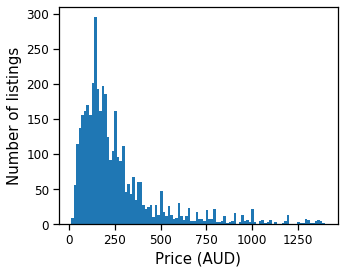

In [4]:
plt.figure(figsize=(5, 4))
plt.hist(y_train, bins=100);
plt.xlabel('Price (AUD)')
plt.ylabel('Number of listings')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')

## <font color = '#e64626'><a id='feature_engineering'>3. Feature Engineering</a></font>

In [180]:
sydney = gpd.read_file('SA2_sydney/sydney_SA2.shp')
sydney['region'] = sydney['geometry']
geo_train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.longitude, train.latitude))
sydney.crs = "EPSG:7844"
geo_train.crs = "EPSG:7844"
geo_train_join = gpd.tools.sjoin(geo_train, sydney[['SA2_NAME21','geometry','region']], predicate="within", how='left')

In [181]:
geo_nan = geo_train_join[geo_train_join['SA2_NAME21'].isna()][['latitude','longitude']]
geo_nan = gpd.GeoDataFrame(geo_nan, geometry=gpd.points_from_xy(geo_nan.longitude, geo_nan.latitude))
geo_nan.crs = "EPSG:7844"

In [182]:
for i in geo_nan.index:
    geo_train_join.loc[i,'SA2_NAME21'] = sydney.loc[sydney.distance(geo_nan.loc[i,'geometry']).sort_values().index[0],'SA2_NAME21']
# geo_train_join.loc[geo_nan.index,['SA2_NAME21','neighbourhood_cleansed','latitude','longitude']][0:50]

/var/folders/nq/xtfndg6x53g0ffw66wk7g0100000gn/T/ipykernel_10248/2648550054.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_train_join.loc[i,'SA2_NAME21'] = sydney.loc[sydney.distance(geo_nan.loc[i,'geometry']).sort_values().index[0],'SA2_NAME21']


In [203]:
geo_plot_df = pd.DataFrame(geo_train_join[:4000].groupby('SA2_NAME21').mean()['price'])
geo_plot_df['median'] = geo_train_join[:4000].groupby('SA2_NAME21').median()['price']

In [252]:
np.log(geo_plot_df)

,price,median
SA2_NAME21,,
Annandale (NSW),5.191201,4.916325
Arncliffe - Bardwell Valley,4.950885,4.959342
Artarmon,6.062622,6.062622
Ashcroft - Busby - Miller,4.787492,4.787492
Ashfield - North,4.025352,3.912023
...,...,...
Woollahra,5.757148,5.533389
Woolooware - Burraneer,6.391359,6.308098
Yagoona - Birrong,4.718499,4.718499


In [209]:
sydney_plot = sydney.set_index('SA2_NAME21')

In [254]:
geo_plot = pd.concat([sydney_plot,np.log(geo_plot_df)],axis=1)

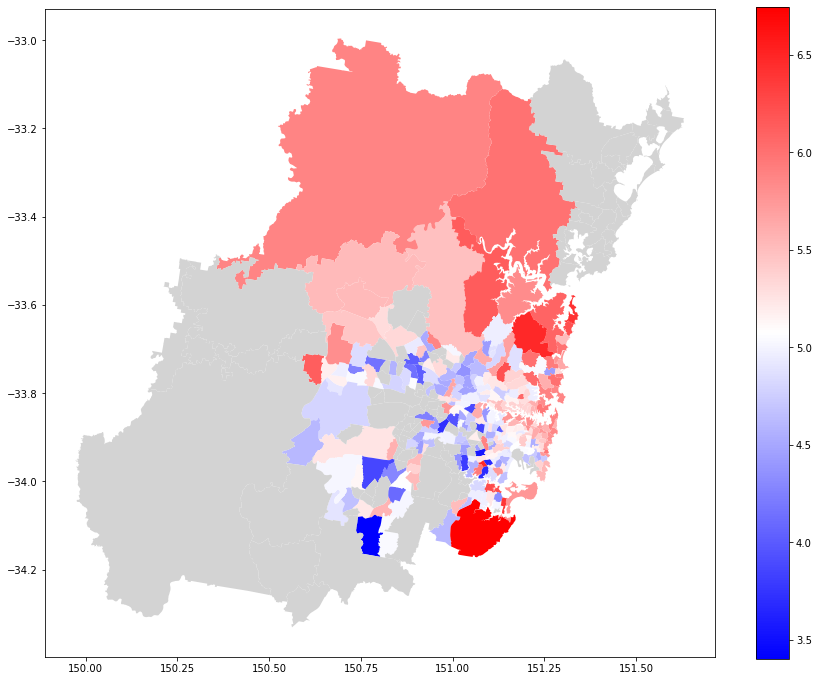

In [259]:
geo_plot.plot(column='price',figsize=(15,12),legend=True,cmap='bwr',missing_kwds= dict(color = "lightgrey"))
plt.show()



## <font color = '#e64626'><a id='methodology'>4. Methodology</a></font>

### <font color = '#e64626'><a id='model_1'>4.1. Model 1: Baseline</a></font>

This is a very simple model where we predict the average house price every time, i.e.

$$\hat{y}=\bar{y}$$

The models you build should be much more interesting than this one!

In [5]:
mean_price = np.mean(y_train)
print('Mean price: ${:.2f}'.format(mean_price))

Mean price: $269.46


Now we need to generate the submission file.

In [6]:
id_col = np.arange(2000).reshape(-1, 1)
y_pred = mean_price*np.ones(2000).reshape(-1, 1)

data = np.hstack((id_col, y_pred))

m1_submission = pd.DataFrame(data, columns=['id', 'price'])
m1_submission['id'] = m1_submission['id'].astype('int')

m1_submission.to_csv('model1_submission.csv', index=False)

### <font color = '#e64626'><a id='model_2'>4.2. Model 2: *model name*</a></font>

### <font color = '#e64626'><a id='model_3'>4.2. Model 3: *model name*</a></font>

### <font color = '#e64626'><a id='model_4'>4.2. Model 4: *model name*</a></font>

### <font color = '#e64626'><a id='mode_5'>4.2. Model 5: *model name*</a></font>